In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm
import tqdm
import math
import QuantLib as ql
import numpy_financial as npf
# pip install numpy-financial
import scipy.optimize as optimize
from datetime import date
import pandas as pd

# 1. Simulate interest rate

### CIR Model

In [2]:
def generate_CIR(kappa,theta,sigma,r0,WAM,num_paths):
    # Generate interest rate 
    T=WAM/12
    h=1/12 # dt
    N=WAM
    size=num_paths
    r=np.ones((1,size))*r0
    zero=np.zeros(size)
    Z1=np.random.normal(0,1,(N,size))
    for i in range(N):
        m=r[i,:]+kappa*(theta-np.max([r[i,:],zero],axis=0))*h+sigma*np.sqrt(np.max([r[i,:],zero],axis=0))*np.sqrt(h)*Z1[i,:]
        r=np.append(r,[m],axis=0)
    return r

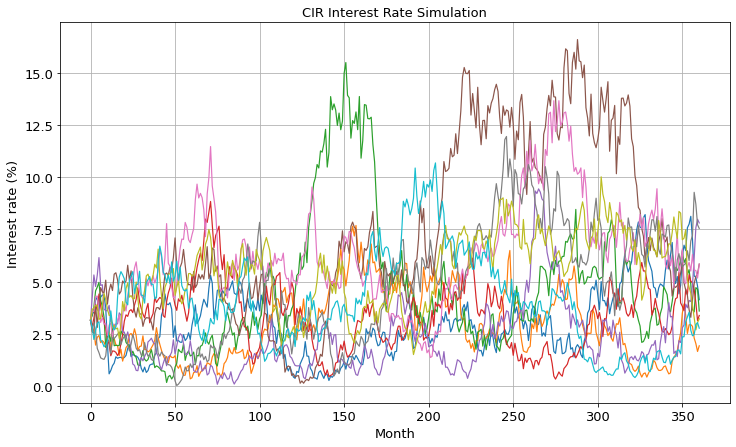

In [3]:
interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10)

plt.figure(figsize=(12,7))
for i in range(interest_paths.shape[1]):
    plt.plot(interest_paths[:,i]*100, lw=1.2)
plt.title("CIR Interest Rate Simulation",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("Interest rate (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

# 2. Prepayment

In [16]:
def prepayment(WAC,WAM,B0,interest_paths,num_paths):
    # Refinancing incentive
    RI=(WAC+0.0075)/(interest_paths[1:,:]+0.02)
#     RI=.2406-.1389*np.arctan(5.952*(1.089-(WAC+0.0075)/interest_paths[1:,:]))

    # Seasoning multiplier, unit: %
    a=np.array([[x+1 for x in range(WAM)] for x in range(num_paths)]).T
    Age=np.min([a/30,np.ones((WAM,num_paths))],axis=0)

    # Monthly multiplie, WANxnum_paths matrix
    temp=np.array([0.94,0.76,0.74,0.95,0.98,0.92,0.98,1.10,1.18,1.22,1.23,0.98])
    testf=np.ones(WAM)
    for i in range(WAM):
        index=(i+6)%12
        testf[i]=temp[index]
    MM=np.array([testf for x in range(num_paths)]).T

    # Burnout multiplier
    B=np.ones((1,num_paths))*B0 # Need to revise
    for i in range(WAM-1):
        n=B[-1,:]*0.8
        B=np.append(B,[n],axis=0)
    BM=0.3+0.7*(B/B0)

    # CPR
    CPR=np.maximum(RI*Age*MM*BM,np.zeros((WAM,num_paths)))
#     CPR=np.minimum(CPR,np.ones((WAM,num_paths))*0.5)
    return CPR,RI,Age,MM,BM

In [17]:
CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths,num_paths=10)

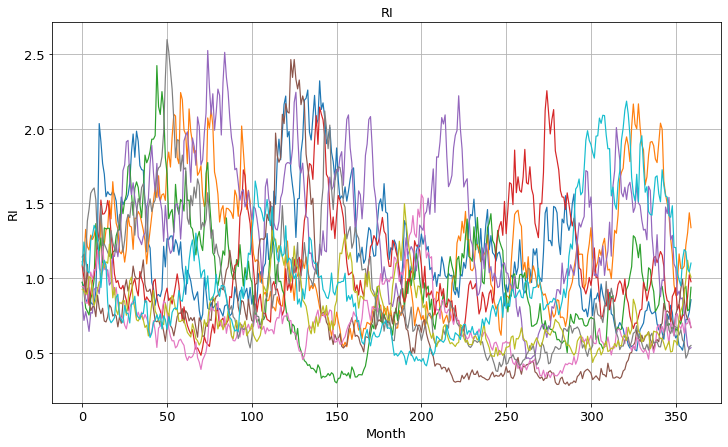

In [18]:
plt.figure(figsize=(12,7))
plt.plot(RI,lw=1.2)
plt.title("RI",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("RI",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

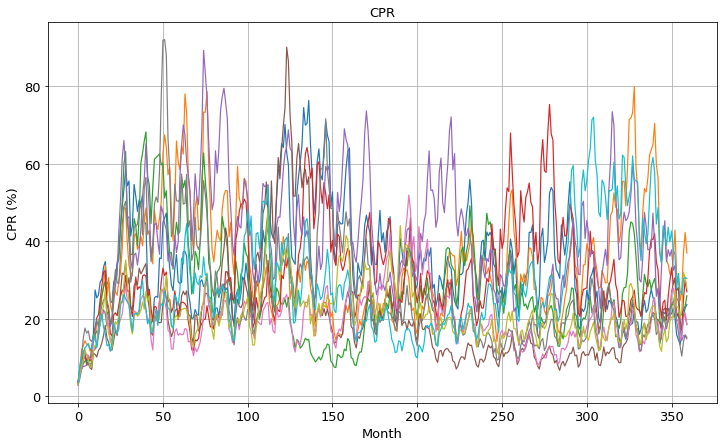

In [19]:
plt.figure(figsize=(12,7))
plt.plot(CPR*100,lw=1.2)
plt.title("CPR",fontsize=13)
plt.xlabel("Month",fontsize=13)
plt.ylabel("CPR (%)",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.show()

# 3. Cash flow

### Generate matrix:

In [8]:
def generate_CF(CPR_matrix,B0,WAC_month,WAM,num_paths):
    CPR=CPR_matrix
    # genarate period / date series
    period=np.array([[x for x in range(0,WAM+1)] for x in range(num_paths)]).T

    # generate MB
    MB=np.ones((WAM+1,num_paths))*B0

    # # generate Mortgage payment
    MP0=-1*npf.pmt(rate=WAC_month,nper=WAM-1,pv=B0)
    MP=np.ones((WAM+1,num_paths))*MP0

    # generate interest payment
    IP=MB*WAC_month

    # generate principal paying in mortgage payment
    PrinP=MP-IP

    # generate prepayment in mortgage payment
    CPR0=0.04
    SMM0=1-np.power(1-CPR0,1/12)
    PrePay=(MB-PrinP)*SMM0

    # generate cash flow 
    CF=MP+PrePay

    # Calculate all cash flow table in matrix
    for i in range(1,WAM): # i from 1 to 359
        MB[i,:]=MB[i-1,:]-PrinP[i-1,:]-PrePay[i-1,:]
        MP[i,:]=-1*npf.pmt(rate=WAC_month,nper=WAM-i,pv=MB[i,:])
        IP[i,:]=MB[i-1,:]*WAC_month
        PrinP[i,:]= MP[i,:]-IP[i,:]
        PrePay[i,:]=(MB[i,:]-PrinP[i,:])*CPR[i-1,:]/100 # Here CPR is monthly rate
        CF[i,:]=IP[i,:]+PrinP[i,:]+PrePay[i,:]

    MB[-1,:]=0
    IP[-1,:]=MB[-2,:]*WAC_month
    MP[-1,:]=MB[-2,:]+IP[-1,:]
    PrinP[-1,:]=MB[-2,:]
    PrePay[-1,:]=0
    CF[-1,:]=MP[-1,:]
    return period,MB,MP,IP,PrinP,PrePay,CF

In [20]:
period,MB,MP,IP,PrinP,PrePay,CF = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=10)

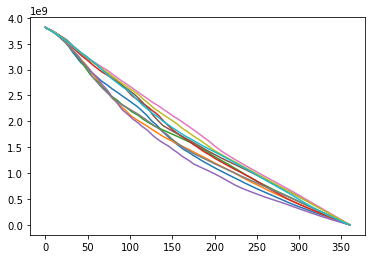

In [21]:
plt.plot(MB)
plt.show()

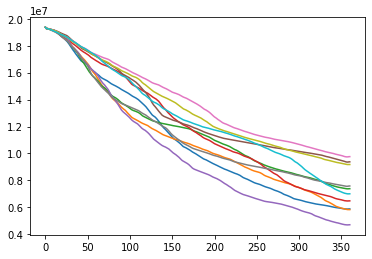

In [22]:
plt.plot(MP)
plt.show()

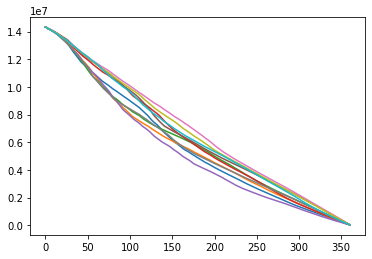

In [23]:
plt.plot(IP)
plt.show()

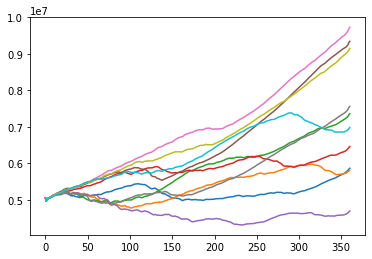

In [24]:
plt.plot(PrinP)
plt.show()

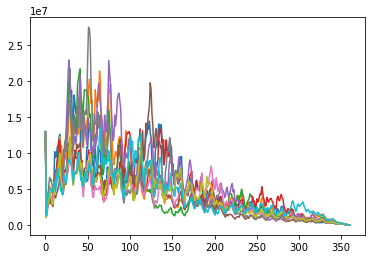

In [25]:
plt.plot(PrePay)
plt.show()

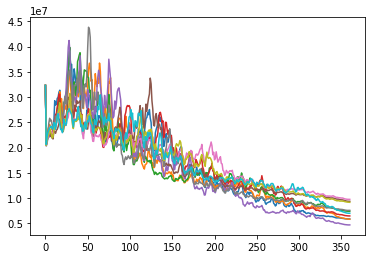

In [26]:
plt.plot(CF)
plt.show()

### cash flow table (one example)

In [27]:
unit=1000000
frame = {'Time':pd.Series(period[:,0]),'Mortgage_Balance ($M)':pd.Series(np.round_(MB[:,0]/unit,decimals=2)),
         'Mortgage_Payment ($M)':pd.Series(np.round_(MP[:,0]/unit,decimals=2)), 'Interest_Payment ($M)':pd.Series(np.round_(IP[:,0]/unit,decimals=2)),
         'Principal_Payment ($M)':pd.Series(np.round_(PrinP[:,0]/unit,decimals=2)), 'Prepayment ($M)':pd.Series(np.round_(PrePay[:,0]/unit,decimals=2)),
         'Cash Flow ($M)':pd.Series(np.round_(CF[:,0]/unit,decimals=2))}
CF_table=pd.DataFrame(frame)
CF_table

,Time,Mortgage_Balance ($M),Mortgage_Payment ($M),Interest_Payment ($M),Principal_Payment ($M),Prepayment ($M),Cash Flow ($M)
0,0,3817.75,19.37,14.32,5.05,12.95,32.32
1,1,3799.75,19.28,14.32,4.96,1.20,20.48
2,2,3793.59,19.27,14.25,5.02,2.25,21.52
3,3,3786.31,19.26,14.23,5.04,2.87,22.13
4,4,3778.41,19.25,14.20,5.05,3.39,22.63
...,...,...,...,...,...,...,...
356,356,23.29,5.88,0.11,5.77,0.02,5.90
357,357,17.50,5.88,0.09,5.79,0.02,5.90
358,358,11.69,5.88,0.07,5.81,0.01,5.89
359,359,5.87,5.89,0.04,5.84,0.00,5.89


# 4. MBS Valuation

### Present Value, YTM, quotes

In [28]:
def MBS_price(CF_matrix,interest_paths,period_matrix,B0,WAC_month,OAS):
    CF=CF_matrix
    period=period_matrix
    # Find NPV
    DCF=CF[1:,:]/((1+interest_paths[1:,:]/12+OAS/12)**(period[1:,:]))
    PV=np.sum(DCF,axis=0)
    bond_quotes=(PV/B0)*100
    print("Bond Quotes: {}".format(round(np.mean(bond_quotes),4)))

    guess=0.01
    # ytm_func = lambda y: np.sum(CF[1:,:]/((1+y/12)**(period[1:,:])),axis=0) - PV
    ytm_func = lambda y: \
        sum([B0*WAC_month/(1+y)**(t) for t in period[1:,0]]) + \
        B0/(1+y)**(period[-1,0]) - np.mean(PV)
    ytm=optimize.newton(ytm_func, guess)
    
    print("Yield to Maturity (Annualized):  %.2f%%" % (ytm*1200))
    return bond_quotes,PV,ytm*12

In [29]:
bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0.015)

Bond Quotes: 90.0516
Yield to Maturity (Annualized):  5.15%


### Compare with real price:

In [44]:
df=pd.read_csv('UM30_HP_0615.csv').dropna()
df.DATES=pd.to_datetime(df.DATES)
discount_rate=np.mean(interest_paths[0,:])
df['Esti']=np.mean(bond_quotes)/(1+discount_rate/365)**df['t_diff']

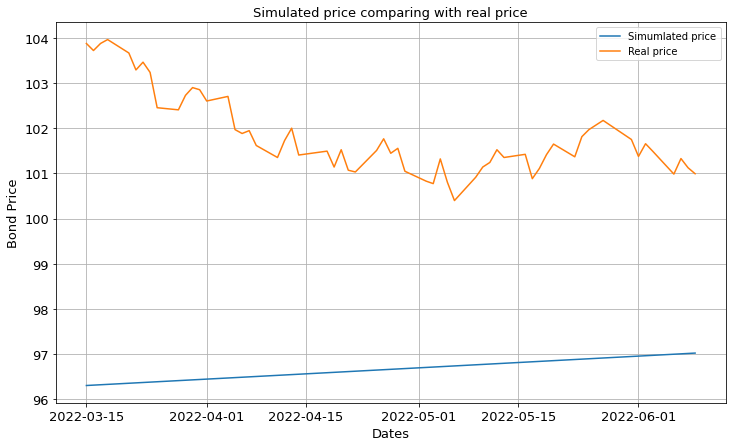

In [45]:
plt.figure(figsize=(12,7))
plt.plot(df.DATES,df.Esti,label='Simumlated price')
plt.plot(df.DATES,df.price,label='Real price')
plt.title("Simulated price comparing with real price",fontsize=13)
plt.xlabel("Dates",fontsize=13)
plt.ylabel("Bond Price",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()
plt.legend()
plt.show()

### Duration:

In [36]:
interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10000)
CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths,num_paths=10000)
period,MB,MP,IP,PrinP,PrePay,CF = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=10000)
bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0.015)

Bond Quotes: 97.074
Yield to Maturity (Annualized):  4.68%


In [47]:
ytm

0.04681721267677632

### Duration:

### Calculate duration by changing interest rate:

In [42]:
# change small interest rate
def duration_interest(delta,num_paths):
    interest_paths=generate_CIR(kappa=0.2,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=num_paths)

    CPR,RI,Age,MM,BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths,num_paths=num_paths)
    new_CPR,new_RI,new_Age,new_MM,new_BM=prepayment(WAC=0.045,WAM=360,B0=3817752472,interest_paths=interest_paths+delta,num_paths=num_paths)

    period,MB,MP,IP,PrinP,PrePay,CF = generate_CF(CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=num_paths)
    new_period,new_MB,new_MP,new_IP,new_PrinP,new_PrePay,new_CF = generate_CF(new_CPR,B0=3817752472,WAC_month=0.045/12,WAM=360,num_paths=num_paths)

    bond_quotes,PV,ytm=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=0.045/12,OAS=0.015)
    new_bond_quotes,new_PV,new_ytm=MBS_price(new_CF,interest_paths+delta,new_period,B0=3817752472,WAC_month=0.045/12,OAS=0.015)
    return (np.mean(bond_quotes)-np.mean(new_bond_quotes))/delta

In [43]:
duration_interest(delta=0.00001,num_paths=10000)

Bond Quotes: 98.7298
Yield to Maturity (Annualized):  4.58%
Bond Quotes: 98.7207
Yield to Maturity (Annualized):  4.58%


913.8920861417431

### Calculate duration by changing ytm:

In [46]:
def duration_ytm(delta,ytm,B0,WAC_month):
    new_ytm=(ytm*100+delta)/100
    old_BP=(sum([B0*WAC_month/(1+ytm)**(t) for t in period[1:,0]])+B0/(1+ytm)**(period[-1,0]))*100/B0
    new_BP=(sum([B0*WAC_month/(1+new_ytm)**(t) for t in period[1:,0]])+B0/(1+new_ytm)**(period[-1,0]))*100/B0
    duration=(old_BP-new_BP)/delta
    return duration

In [48]:
duration_ytm(delta=0.000001,ytm=ytm,B0=3817752472,WAC_month=0.045/12)

1.7109041188234642

### Make a yield curve:

In [ ]:
# Adjust YTM
ytm_list=np.arange(0.02,0.08,0.00001)/12 # monthly
bp_dur=np.ones(len(ytm_list))
for i in range(len(ytm_list)):
    ytm=ytm_list[i]
    bp_dur[i]=(sum([B0*WAC_month/(1+ytm)**(t) for t in period[1:,0]])+B0/(1+ytm)**(period[-1,0]))*100/B0

In [ ]:
plt.figure(figsize=(12,7))
plt.title('Yield Curve')
plt.plot(ytm_list*1200,bp_dur)
plt.xlabel('Bond yield (%)')
plt.ylabel('Bond price')
plt.grid()
plt.show()

### Change coupon rate

In [ ]:
cp_list=np.array([0.03,0.035,0.04,0.045,0.05])
Quotes_cp=np.ones(len(cp_list))
YTM_cp=np.ones(len(cp_list))
Duration_cp=np.ones(len(cp_list))
for i in range(len(cp_list)):
    interest_paths=generate_CIR(kappa=0.29368,theta=0.039,sigma=0.1,r0=0.0315,WAM=360,num_paths=10000)
    CPR,RI,Age,MM,BM=prepayment(WAC=cp_list[i],WAM=360,B0=3817752472,interest_paths=interest_paths,num_paths=10000)
    period,MB,MP,IP,PrinP,PrePay,CF = generate_CF(CPR,B0=3817752472,WAC_month=cp_list[i]/12,WAM=360,num_paths=10000)
    a,b,c=MBS_price(CF,interest_paths,period,B0=3817752472,WAC_month=cp_list[i]/12)
    Quotes_cp[i]=np.mean(a)
    YTM_cp[i]=c
    Duration_cp[i]=duration_ytm(delta=0.000001,ytm=c,B0=3817752472,WAC_month=cp_list[i]/12)

In [ ]:
plt.title('YTM - Coupon')
plt.plot(cp_list*100,YTM_cp*100)
plt.xlabel('Coupon (%)')
plt.ylabel('YTM (%)')
plt.grid()
plt.show()

In [ ]:
Duration_cp

In [ ]:
plt.title('Duration - Coupon')
plt.plot(cp_list*100,Duration_cp)
plt.xlabel('Coupon (%)')
plt.ylabel('Duration (Year)')
plt.grid()
plt.show()